In [265]:
import praw
import pandas as pd
from datetime import datetime, timedelta
import time
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
import pytz

In [91]:
reddit = praw.Reddit(
    client_id="Gdr88UlekXQoVBVQd1moig",
    client_secret="WHAbASIdXelrbhf96Ol-1WtU7DoHFg",
    user_agent="ThreadInsight/0.1 by Dry_Wolverine7741"
)

In [93]:
subreddit_name = "learnpython"
days_to_fetch = 3
max_posts = 500  
subscribers = None
post_workers = 2
comment_workers = 3

In [197]:
def fetch_recent_posts():
    all_posts = []
    subreddit_instance = reddit.subreddit(subreddit_name)

    start_time = datetime.utcnow() - timedelta(days=days_to_fetch)
    start_timestamp = int(start_time.timestamp())

    print(f"Fetching only posts from the last {days_to_fetch} days in r/{subreddit_name}...")

    post_list = []
    backoff_time = 1

    print("Fetching subreddit metadata (subscribers)...")
    subscribers = subreddit_instance.subscribers

    while True:
        try:
            for post in subreddit_instance.new(limit=max_posts):
                if post.created_utc < start_timestamp:
                    break
                post_list.append(post)

            post_list.sort(key=lambda x: x.created_utc, reverse=True)
            print(f"Found {len(post_list)} recent posts.")
            break

        except praw.exceptions.APIException as e:
            if "RATELIMIT" in str(e):
                print(f"Rate limit exceeded. Sleeping {backoff_time}s before retrying...")
                time.sleep(backoff_time)
                backoff_time *= 2
            else:
                raise e

    def process_post(post):
        post_type = "Text"
        if post.url.endswith((".jpg", ".png", ".gif", ".jpeg")):
            post_type = "Image"
        elif "v.redd.it" in post.url:
            post_type = "Video"

        try:
            account_age_days = (
                (datetime.utcnow() - datetime.utcfromtimestamp(post.author.created_utc)).days
                if post.author and hasattr(post.author, "created_utc")
                else None
            )
        except:
            account_age_days = None

        return {
            "id": post.id,
            "author": post.author.name if post.author else "[deleted]",
            "title": post.title,
            "selftext": post.selftext,
            "is_self": post.is_self,
            "num_comments": post.num_comments,
            "over_18": post.over_18,
            "spoiler": post.spoiler,
            "locked": post.locked,
            "gilded": post.gilded,
            "upvotes": post.score,
            "created_utc": post.created_utc,
            "post_type": post_type,
            "account_age_days": account_age_days
        }

    with ThreadPoolExecutor(max_workers=post_workers) as executor:
        futures = [executor.submit(process_post, post) for post in post_list]

        for count, future in enumerate(as_completed(futures), start=1):
            result = future.result()
            if result:
                all_posts.append(result)

            if count % 100 == 0:
                print(f"Processed {count}/{len(post_list)} posts... Sleeping for 1s.")
                time.sleep(1)

    print(f"Fetched {len(all_posts)} recent posts from r/{subreddit_name}.")
    return all_posts


def fetch_comments(post_id):
    backoff_time = 2
    while True:
        try:
            submission = reddit.submission(id=post_id)
            submission.comments.replace_more(limit=0)

            comments = []
            for comment in submission.comments.list():
                comments.append({
                    "comment_id": comment.id,
                    "comment_author": comment.author.name if comment.author else "[deleted]",
                    "comment_upvotes": comment.score,
                    "comment_created_utc": comment.created_utc,
                    "post_id": post_id
                })

            return comments

        except praw.exceptions.APIException as e:
            if "RATELIMIT" in str(e):
                print(f"Rate limit on comments. Sleeping {backoff_time}s before retrying...")
                time.sleep(backoff_time)
                backoff_time *= 2
            else:
                print(f"Error fetching comments for post {post_id}: {e}")
                return []


def fetch_comments_parallel(posts):
    all_comments = []
    with ThreadPoolExecutor(max_workers=comment_workers) as executor:
        future_to_post = {executor.submit(fetch_comments, post["id"]): post["id"] for post in posts}

        for count, future in enumerate(as_completed(future_to_post), start=1):
            post_id = future_to_post[future]
            try:
                all_comments.extend(future.result())
            except Exception as exc:
                print(f"Exception fetching comments for post {post_id}: {exc}")

            if count % 50 == 0:
                print(f"Processed comments for {count} posts... Sleeping for 0.5s.")
                time.sleep(0.5)
        print(f"Processed {len(all_comments)} comments.")

    return all_comments

start_time = time.time()

posts = fetch_recent_posts()
all_comments = fetch_comments_parallel(posts)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Total Execution Time: {elapsed_time:.2f} seconds.")

Fetching only posts from the last 3 days in r/learnpython...
Fetching subreddit metadata (subscribers)...
Found 97 recent posts.
Fetched 97 recent posts from r/learnpython.
Processed comments for 50 posts... Sleeping for 0.5s.
Processed 752 comments.
Total Execution Time: 37.36 seconds.


In [27]:
len(all_comments)

222

In [17]:
len(posts)

28

In [227]:
df_posts = pd.DataFrame(posts)

In [201]:
df_posts

,id,author,title,selftext,is_self,num_comments,over_18,spoiler,locked,gilded,upvotes,created_utc,post_type,account_age_days
0,1j2jhzb,icarophnx,Seconds conversion using python program / conv...,"I've just created my first python program, and...",True,5,False,False,False,0,1,1.741011e+09,Text,1403
1,1j2j80o,Amazing-Gift-2152,Parser for classes,Im coding a compiler and want to know how the ...,True,0,False,False,False,0,3,1.741010e+09,Text,153
2,1j2itbh,Tricky_Let1620,TextFSM Assistance,Hi\n\nWorking on getting into the automation w...,True,0,False,False,False,0,1,1.741009e+09,Text,763
3,1j2iczr,NationalAdvice9452,Want to start learning Python any tips..🙂,I am starting to learn Python so any tips and ...,True,7,False,False,False,0,1,1.741008e+09,Text,641
4,1j2i5a5,OndraTep,How to prevent user from entering malicious co...,Hello everyone!\n\nI'm currently working on a ...,True,3,False,False,False,0,6,1.741007e+09,Text,2297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,1j0itn6,AdTypical7284,Python for JS Developer: Recommendations for L...,Hello fellow Redditors!\n\nI'm primarily a Jav...,True,1,False,False,False,0,0,1.740778e+09,Text,1592
93,1j0ieaq,OhFuckThatWasDumb,What if i forget to close() ?,"I have made a discord bot, which of course is ...",True,33,False,False,False,0,16,1.740777e+09,Text,1579
94,1j0iddh,GoBeyondBeRelentless,"How to create flask server and ""dummy"" files t...","Hi all, I saw this video https://youtu.be/CV8r...",True,7,False,False,False,0,0,1.740777e+09,Text,94
95,1j0gz5d,Kawatigood,Any OCR wizards that can help me increase accu...,"Hi pythoners, i am currently working on a scri...",True,2,False,False,False,0,1,1.740773e+09,Text,1263


In [203]:
df_comments = pd.DataFrame(all_comments)

In [191]:
df_comments

,comment_id,comment_author,comment_upvotes,comment_created_utc,post_id
0,mfs79bt,baghiq,1,1.741012e+09,1j2jhzb
1,mfs7exf,JeLuF,1,1.741012e+09,1j2jhzb
2,mfrwq4x,schoolmonky,2,1.741008e+09,1j2hjlj
3,mfrt81e,klmsa,1,1.741006e+09,1j2hjlj
4,mfrtdi4,FVMF1984,1,1.741006e+09,1j2hjlj
...,...,...,...,...,...
737,mfejq7f,GertVanAntwerpen,2,1.740819e+09,1j0ieaq
738,mfeo78o,NYX_T_RYX,1,1.740821e+09,1j0ieaq
739,mffce5q,Brian,2,1.740835e+09,1j0ieaq
740,mfeh87n,OhFuckThatWasDumb,1,1.740817e+09,1j0ieaq


In [119]:
df_posts["post_type"].value_counts()

post_type
Text    97
Name: count, dtype: int64

In [123]:
df_posts["spoiler"].value_counts()

spoiler
False    97
Name: count, dtype: int64

In [125]:
df_posts["gilded"].value_counts()

gilded
0    97
Name: count, dtype: int64

In [127]:
df_posts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                97 non-null     object 
 1   author            97 non-null     object 
 2   title             97 non-null     object 
 3   selftext          97 non-null     object 
 4   is_self           97 non-null     bool   
 5   over_18           97 non-null     bool   
 6   spoiler           97 non-null     bool   
 7   locked            97 non-null     bool   
 8   gilded            97 non-null     int64  
 9   upvotes           97 non-null     int64  
 10  created_utc       97 non-null     float64
 11  post_type         97 non-null     object 
 12  account_age_days  97 non-null     int64  
 13  hour              97 non-null     int32  
dtypes: bool(4), float64(1), int32(1), int64(3), object(5)
memory usage: 7.7+ KB


In [229]:
df_posts["created_utc"] = pd.to_datetime(df_posts["created_utc"], unit="s")

In [231]:
df_posts["created_utc"]

0    2025-03-03 14:11:01
1    2025-03-03 13:57:52
2    2025-03-03 13:36:49
3    2025-03-03 13:12:51
4    2025-03-03 13:01:33
             ...        
92   2025-02-28 21:27:56
93   2025-02-28 21:09:28
94   2025-02-28 21:08:19
95   2025-02-28 20:08:22
96   2025-02-28 20:48:12
Name: created_utc, Length: 97, dtype: datetime64[ns]

In [233]:
df_posts["created_date"] = df_posts["created_utc"].dt.date
df_posts["created_time"] = df_posts["created_utc"].dt.time

In [235]:
df_posts

,id,author,title,selftext,is_self,num_comments,over_18,spoiler,locked,gilded,upvotes,created_utc,post_type,account_age_days,created_date,created_time
0,1j2jhzb,icarophnx,Seconds conversion using python program / conv...,"I've just created my first python program, and...",True,5,False,False,False,0,1,2025-03-03 14:11:01,Text,1403,2025-03-03,14:11:01
1,1j2j80o,Amazing-Gift-2152,Parser for classes,Im coding a compiler and want to know how the ...,True,0,False,False,False,0,3,2025-03-03 13:57:52,Text,153,2025-03-03,13:57:52
2,1j2itbh,Tricky_Let1620,TextFSM Assistance,Hi\n\nWorking on getting into the automation w...,True,0,False,False,False,0,1,2025-03-03 13:36:49,Text,763,2025-03-03,13:36:49
3,1j2iczr,NationalAdvice9452,Want to start learning Python any tips..🙂,I am starting to learn Python so any tips and ...,True,7,False,False,False,0,1,2025-03-03 13:12:51,Text,641,2025-03-03,13:12:51
4,1j2i5a5,OndraTep,How to prevent user from entering malicious co...,Hello everyone!\n\nI'm currently working on a ...,True,3,False,False,False,0,6,2025-03-03 13:01:33,Text,2297,2025-03-03,13:01:33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,1j0itn6,AdTypical7284,Python for JS Developer: Recommendations for L...,Hello fellow Redditors!\n\nI'm primarily a Jav...,True,1,False,False,False,0,0,2025-02-28 21:27:56,Text,1592,2025-02-28,21:27:56
93,1j0ieaq,OhFuckThatWasDumb,What if i forget to close() ?,"I have made a discord bot, which of course is ...",True,33,False,False,False,0,16,2025-02-28 21:09:28,Text,1579,2025-02-28,21:09:28
94,1j0iddh,GoBeyondBeRelentless,"How to create flask server and ""dummy"" files t...","Hi all, I saw this video https://youtu.be/CV8r...",True,7,False,False,False,0,0,2025-02-28 21:08:19,Text,94,2025-02-28,21:08:19
95,1j0gz5d,Kawatigood,Any OCR wizards that can help me increase accu...,"Hi pythoners, i am currently working on a scri...",True,2,False,False,False,0,1,2025-02-28 20:08:22,Text,1263,2025-02-28,20:08:22


In [237]:
df_posts.drop(columns = ["created_utc"], axis = 1, inplace = True)

In [211]:
df_posts

,id,author,title,selftext,is_self,num_comments,over_18,spoiler,locked,gilded,upvotes,post_type,account_age_days,created_date,created_time
0,1j2jhzb,icarophnx,Seconds conversion using python program / conv...,"I've just created my first python program, and...",True,5,False,False,False,0,1,Text,1403,2025-03-03,14:11:01
1,1j2j80o,Amazing-Gift-2152,Parser for classes,Im coding a compiler and want to know how the ...,True,0,False,False,False,0,3,Text,153,2025-03-03,13:57:52
2,1j2itbh,Tricky_Let1620,TextFSM Assistance,Hi\n\nWorking on getting into the automation w...,True,0,False,False,False,0,1,Text,763,2025-03-03,13:36:49
3,1j2iczr,NationalAdvice9452,Want to start learning Python any tips..🙂,I am starting to learn Python so any tips and ...,True,7,False,False,False,0,1,Text,641,2025-03-03,13:12:51
4,1j2i5a5,OndraTep,How to prevent user from entering malicious co...,Hello everyone!\n\nI'm currently working on a ...,True,3,False,False,False,0,6,Text,2297,2025-03-03,13:01:33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,1j0itn6,AdTypical7284,Python for JS Developer: Recommendations for L...,Hello fellow Redditors!\n\nI'm primarily a Jav...,True,1,False,False,False,0,0,Text,1592,2025-02-28,21:27:56
93,1j0ieaq,OhFuckThatWasDumb,What if i forget to close() ?,"I have made a discord bot, which of course is ...",True,33,False,False,False,0,16,Text,1579,2025-02-28,21:09:28
94,1j0iddh,GoBeyondBeRelentless,"How to create flask server and ""dummy"" files t...","Hi all, I saw this video https://youtu.be/CV8r...",True,7,False,False,False,0,0,Text,94,2025-02-28,21:08:19
95,1j0gz5d,Kawatigood,Any OCR wizards that can help me increase accu...,"Hi pythoners, i am currently working on a scri...",True,2,False,False,False,0,1,Text,1263,2025-02-28,20:08:22


In [213]:
df_comments["comment_created_utc"] = pd.to_datetime(df_comments["comment_created_utc"], unit="s")
df_comments["comment_created_date"] = df_comments["comment_created_utc"].dt.date
df_comments["comment_created_time"] = df_comments["comment_created_utc"].dt.time
df_comments.drop(columns = ["comment_created_utc"], axis = 1, inplace = True)

In [215]:
df_comments

,comment_id,comment_author,comment_upvotes,post_id,comment_created_date,comment_created_time
0,mfs79bt,baghiq,2,1j2jhzb,2025-03-03,14:22:06
1,mfs7exf,JeLuF,2,1j2jhzb,2025-03-03,14:23:02
2,mfs7hqk,brasticstack,1,1j2jhzb,2025-03-03,14:23:29
3,mfs7sl4,danielroseman,1,1j2jhzb,2025-03-03,14:25:16
4,mfs7pny,JeLuF,1,1j2jhzb,2025-03-03,14:24:47
...,...,...,...,...,...,...
747,mfboy6b,grantrules,2,1j0iddh,2025-02-28,21:34:29
748,mfds9n1,cgoldberg,1,1j0iddh,2025-03-01,04:42:46
749,mfn6xf2,KCRowan,1,1j0iddh,2025-03-02,18:18:44
750,mfiwekf,ES-Alexander,1,1j0gz5d,2025-03-02,00:36:03


In [239]:
df_posts["has_link"] = df_posts["selftext"].str.contains(r'http[s]?://', na=False)

In [241]:
df_posts["has_link"].value_counts()

has_link
False    82
True     15
Name: count, dtype: int64

In [243]:
def remove_links(text):
    return re.sub(r'http[s]?://\S+', '', text)

df_posts["clean_selftext"] = df_posts["selftext"].apply(remove_links)

In [245]:
df_posts

,id,author,title,selftext,is_self,num_comments,over_18,spoiler,locked,gilded,upvotes,post_type,account_age_days,created_date,created_time,has_link,clean_selftext
0,1j2jhzb,icarophnx,Seconds conversion using python program / conv...,"I've just created my first python program, and...",True,5,False,False,False,0,1,Text,1403,2025-03-03,14:11:01,False,"I've just created my first python program, and..."
1,1j2j80o,Amazing-Gift-2152,Parser for classes,Im coding a compiler and want to know how the ...,True,0,False,False,False,0,3,Text,153,2025-03-03,13:57:52,False,Im coding a compiler and want to know how the ...
2,1j2itbh,Tricky_Let1620,TextFSM Assistance,Hi\n\nWorking on getting into the automation w...,True,0,False,False,False,0,1,Text,763,2025-03-03,13:36:49,False,Hi\n\nWorking on getting into the automation w...
3,1j2iczr,NationalAdvice9452,Want to start learning Python any tips..🙂,I am starting to learn Python so any tips and ...,True,7,False,False,False,0,1,Text,641,2025-03-03,13:12:51,False,I am starting to learn Python so any tips and ...
4,1j2i5a5,OndraTep,How to prevent user from entering malicious co...,Hello everyone!\n\nI'm currently working on a ...,True,3,False,False,False,0,6,Text,2297,2025-03-03,13:01:33,False,Hello everyone!\n\nI'm currently working on a ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,1j0itn6,AdTypical7284,Python for JS Developer: Recommendations for L...,Hello fellow Redditors!\n\nI'm primarily a Jav...,True,1,False,False,False,0,0,Text,1592,2025-02-28,21:27:56,False,Hello fellow Redditors!\n\nI'm primarily a Jav...
93,1j0ieaq,OhFuckThatWasDumb,What if i forget to close() ?,"I have made a discord bot, which of course is ...",True,33,False,False,False,0,16,Text,1579,2025-02-28,21:09:28,False,"I have made a discord bot, which of course is ..."
94,1j0iddh,GoBeyondBeRelentless,"How to create flask server and ""dummy"" files t...","Hi all, I saw this video https://youtu.be/CV8r...",True,7,False,False,False,0,0,Text,94,2025-02-28,21:08:19,True,"Hi all, I saw this video and from 6:45 you ca..."
95,1j0gz5d,Kawatigood,Any OCR wizards that can help me increase accu...,"Hi pythoners, i am currently working on a scri...",True,2,False,False,False,0,1,Text,1263,2025-02-28,20:08:22,True,"Hi pythoners, i am currently working on a scri..."


In [247]:
total_posts = len(df_posts)
total_upvotes = df_posts["upvotes"].sum()
average_upvotes = df_posts["upvotes"].mean()
nsfw_posts = df_posts["over_18"].sum()
spoiler_posts = df_posts["spoiler"].sum()
locked_posts = df_posts["locked"].sum()
gilded_posts = df_posts[df_posts["gilded"] > 0].shape[0]

In [249]:
total_comments = len(df_comments)
total_comment_upvotes = df_comments["comment_upvotes"].sum()
average_comment_upvotes = df_comments["comment_upvotes"].mean()

In [251]:
top_posts = df_posts.sort_values("upvotes", ascending=False).head(5)
top_commenters = df_comments["comment_author"].value_counts().head(5)

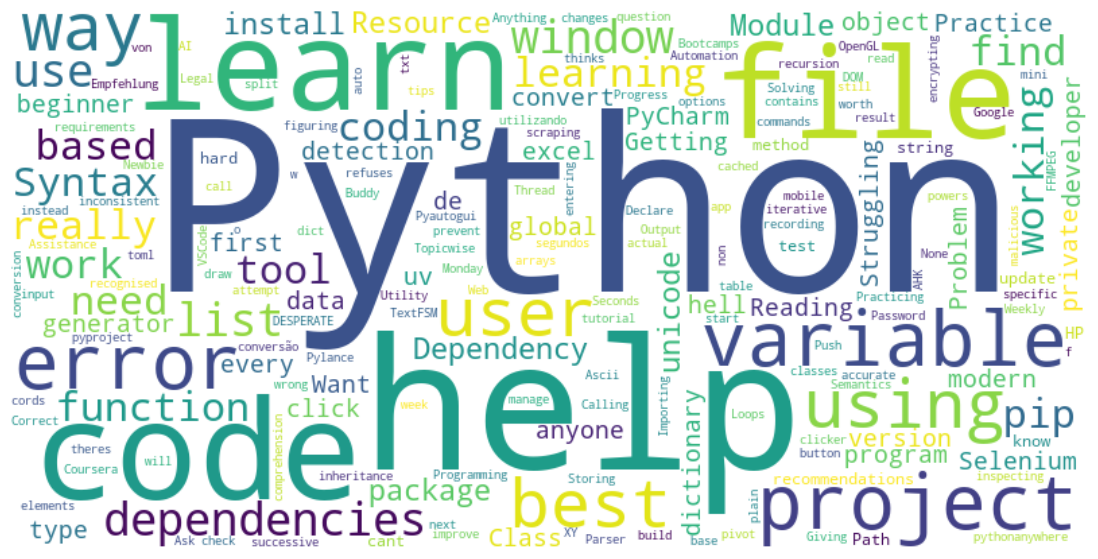

In [267]:
text = " ".join(df_posts["title"].dropna())
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [275]:
df_posts["engagement_score"] = df_posts["upvotes"] + df_posts["num_comments"].fillna(0)
top_engagement_posts = df_posts.sort_values("engagement_score", ascending=False).head(5)

In [271]:
average_account_age = df_posts["account_age_days"].mean()